# Optimization Problem: Ethanol Production Profit Maximization

This notebook solves an optimization problem for **maximizing profit** in ethanol production by optimizing:
- Initial glucose concentration ($C_p$)
- Initial biomass ($X_0$)
- Temperature controller gain ($k_E$)
- pH controller gain ($k_{pH}$)

## Problem Formulation

The objective is to maximize profit (Revenue - Costs):

$$
\max_{C_p, X_0, k_E, k_{pH}} \quad \text{Profit} = \text{Revenue}(C_p, X_0, k_E, k_{pH}) - \text{Total Cost}(C_p, X_0, k_E, k_{pH})
$$




## Mathematical Formulation

The complete optimization problem is:

$$\boxed{
\begin{aligned}
\max_{C_p,X_0,k_E,k_{pH}} \quad & \text{Profit} = R(C_p, X_0, k_E, k_{pH}) - C(C_p, X_0, k_E, k_{pH}) \\
[6pt]
\text{where:} \\
& R = \text{Revenue function with interactions} \\
& C = \text{Cost function with cross-terms and higher-order dependencies} \\
[6pt]
\text{s.t.} \quad &20 \le C_p \le 200 \\
&0.1 \le X_0 \le 1.8 \\
&0.005 \le k_E \le 0.02 \\
&0.001 \le k_{pH} \le 0.01
\end{aligned}
}$$

**Note**: Constraints are extended and objective is designed with **interacting terms** to ensure internal optima. We'll use **penalty method with indicator functions** to convert to an unconstrained problem using **standard BFGS**.


## Import Required Libraries

We'll use:
- `numpy` for numerical computations
- `scipy.optimize` for BFGS optimization
- `matplotlib` for visualization


In [210]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Define Problem Parameters

We define parameters for the profit function with interacting terms:

- **Extended Bounds**: Constraints widened to allow more exploration space
- **Revenue Parameters**: Coefficients for saturating revenue function ($R_0$, $K_s$, $\alpha_R$, etc.)
- **Cost Parameters**: Coefficients for quadratic and cross-term costs ($a_i$, $b_i$, $d_i$, $e_i$, etc.)
- **Interaction Parameters**: Reference values and penalties to create optimal regions


In [212]:
# Problem parameters 

# Physical parameters
V = 10000  # L (reactor volume)
Tf = 48.0  # hours (fermentation time)

# Biological parameters
Y_max = 0.45  # Maximum ethanol yield (kg ethanol/kg glucose)
K_s = 50.0  # Monod saturation constant (g/L) - glucose concentration at half-max rate
"""In optimization problems related to biological or biochemical processes (like fermentation, microbial growth, substrate utilization),
the Monod term typically refers to the Monod kinetics used to mathematically describe microbial growth rate as a function of substrate 
concentration."""
k = 0.5  # Biomass saturation constant (L/g) for efficiency term
C_inhib = 200.0  # Inhibition concentration (g/L)

# Economic parameters
Price_EtOH = 1.00  # $/L (ethanol price)
Price_Glucose = 0.5  # $/g (glucose cost)
Price_Yeast = 0.05  # $/g (yeast/biomass cost)

# Biomass cost = Price_Yeast * X_0
alpha = Price_Yeast * 10.0  # Biomass cost coefficient ($/(g/L)²) - quadratic term

# Control cost coefficient: small operational cost
C_control = 2000.0  # $ per unit controller gain

print("Parameters defined:")
print(f"Price_EtOH = ${Price_EtOH}/L")
print(f"Price_Glucose = ${Price_Glucose}/g")
print(f"Price_Yeast = ${Price_Yeast}/g")
print(f"V = {V} L")
print(f"Tf = {Tf} hours")
print(f"Y_max = {Y_max}")
print(f"k = {k} L/g")
print(f"K_s (Monod constant) = {K_s} g/L")
print(f"C_inhib (inhibition constant) = {C_inhib} g/L")
print(f"alpha (biomass cost coefficient) = ${alpha}/(g/L)²")
print(f"C_control (control cost coefficient) = ${C_control}/unit gain")


Parameters defined:
Price_EtOH = $1.0/L
Price_Glucose = $0.5/g
Price_Yeast = $0.05/g
V = 10000 L
Tf = 48.0 hours
Y_max = 0.45
k = 0.5 L/g
K_s (Monod constant) = 50.0 g/L
C_inhib (inhibition constant) = 200.0 g/L
alpha (biomass cost coefficient) = $0.5/(g/L)²
C_control (control cost coefficient) = $2000.0/unit gain


In [213]:
# Define remaining model coefficients and bounds (previously missing)
# Revenue / interaction parameters
# R_0 = 10000.0             # Revenue scale 
R_0 = Price_EtOH * V * Y_max
alpha_R = 3.0             # Biomass saturation coefficient
gamma_1 = 1e-3            # Interaction: C_p * X_0 scaling
gamma_2 = 2000.0          # Interaction: k_E * k_pH scaling

# Cost coefficients (material, biomass, cross-terms)
a_1 = 0.5 * Price_Glucose               # Linear glucose cost coeff
a_2 = 0.002  * Price_Glucose            # Quadratic glucose cost coeff
b_1 = Price_Yeast                   # Linear biomass cost coeff
b_2 = alpha               # Quadratic biomass cost coeff
c_1 = 0.1                 # Cross-term glucose*biomass coeff

d_1 = C_control * 500      # quadratic control scaling
d_2 = C_control * 500
d_3 = C_control * 100
e_1 = 5.00   # controller-glucose interaction
e_2 = 500.00   # controller-biomass interaction


# Constraints
C_p_min, C_p_max = 10.0, 250.0
X_0_min, X_0_max = 0.05, 2.0
k_E_min, k_E_max = 0.005, 0.02
k_pH_min, k_pH_max = 0.001, 0.01

### Objectie Function Formulation 

$$
\max_{C_p, X_0, k_E, k_{pH}} \quad \text{Profit} = \text{Revenue}(C_p, X_0, k_E, k_{pH}) - \text{Total Cost}(C_p, X_0, k_E, k_{pH})
$$

### Revenue Function Design:

**Revenue** = $R(C_p, X_0, k_E, k_{pH})$ captures ethanol production with:

$$R = R_0 \cdot \left( \frac{C_p}{K_s + C_p} \right) \cdot \left( 1 - e^{-\alpha_R X_0} \right) \cdot \left( 1 - \frac{C_p^2}{C_{inhib}^2 + C_p^2} \right) \cdot f_{interaction}(C_p, X_0, k_E, k_{pH})$$

- **Interaction term**: $f_{interaction} = 1 + \gamma_1 \cdot C_p \cdot X_0 + \gamma_2 \cdot k_E \cdot k_{pH}$ 

### Cost Function Design:

**Total Cost** = $C(C_p, X_0, k_E, k_{pH})$ :

$$C = C_{material} + C_{operational}$$

1. **Material Cost**:
$$C_{material} = a_1 C_p + a_2 C_p^2 + b_1 X_0 + b_2 X_0^2 + c_1 C_p X_0$$
3. **Operational Cost**:  
$$C_{operational} = d_1 k_E^2 + d_2 k_{pH}^2 + d_3 k_E k_{pH} + e_1 C_p k_E + e_2 X_0 k_{pH}$$



### Profit Function:

$$\text{Profit} = R(C_p, X_0, k_E, k_{pH}) - C(C_p, X_0, k_E, k_{pH})$$   

In [215]:
def objective_function(x, R_0, K_s, alpha_R, C_inhib, gamma_1, gamma_2,
                       a_1, a_2, b_1, b_2, c_1, d_1, d_2, d_3, e_1, e_2,): 
    
    C_p, X_0, k_E, k_pH = x    #Parmeters to be optimised 

    # Ensure k_E and k_pH are positive
    k_E = max(0, k_E)
    k_pH = max(0, k_pH)

    # ========== REVENUE CALCULATION ==========
    # 1. Monod-like saturation: revenue increases but saturates with glucose
    monod_term = C_p / (K_s + C_p)

    # 2. Biomass saturation: diminishing returns with more biomass
    biomass_saturation = 1 - np.exp(-alpha_R * X_0)

    # 3. Inhibition term: high glucose reduces efficiency
    inhibition_term = 1 - (C_p**2) / (C_inhib**2 + C_p**2)

    # 4. Interaction term: cross-variable effects boost revenue
    #    Higher glucose with more biomass = better efficiency
    #    Better controller tuning = better process control
    interaction_term = 1 + gamma_1 * C_p * X_0 + gamma_2 * k_E * k_pH

    # Total revenue (scaled for large values)
    revenue = R_0 * monod_term * biomass_saturation * inhibition_term * interaction_term

    
    # ========== COST CALCULATIONS ==========
    # 1. Material Cost: Quadratic terms prevent monotonic behavior
    #    Linear + quadratic + cross-term create economies/diseconomies of scale
    material_cost = (a_1 * C_p + a_2 * C_p**2 + 
                     b_1 * X_0 + b_2 * X_0**2 + 
                     c_1 * C_p * X_0)  # Cross-term captures material synergy

    # 2. Operational Cost: Quadratic control terms + interactions
    #    Cross-terms: controller costs depend on process conditions
    operational_cost = (d_1 * k_E**2 + d_2 * k_pH**2 + 
                        d_3 * k_E * k_pH +  # Controller interaction
                        e_1 * C_p * k_E +   # Glucose affects temp control cost
                        e_2 * X_0 * k_pH)   # Biomass affects pH control cost

    # Total cost
    total_cost = material_cost + operational_cost

    # ========== PROFIT ==========
    profit = revenue - total_cost

    # Return negative profit (to minimize, so we maximize profit)
    return -profit


## Bound Constraints

The optimization variables have the following bounds:
- $10 \le C_p \le 250$ (g/L) - Glucose concentration range
- $0.05 \le X_0 \le 2.0$ (g/L) - Initial biomass range
- $0.005 \le k_E \le 0.02$ - Temperature controller gain
- $0.001 \le k_{pH} \le 0.01$ - pH controller gain

In [217]:
bounds = [
    (10, 250),      # C_p bounds (g/L)
    (0.05, 2.0),    # X_0 bounds (g/L)
    (0.005, 0.02),  # k_E bounds
    (0.001, 0.01)   # k_pH bounds
]

In [218]:
# Initial guess (near reference values, within extended bounds)
# Start near the interaction cost reference point to explore the optimal region
initial_guess = np.array([
    100.0,    # C_p: near reference value 
    1.30,      # X_0: near reference value 
    0.007,     # k_E: middle of controller range for energy
    0.007     # k_pH: middle of controller range for pH control
])

# Verify initial guess is within bounds
print("Verifying initial guess is within bounds:")
for i, (var_name, val, (lower, upper)) in enumerate(zip(
    ['C_p', 'X_0', 'k_E', 'k_pH'],
    initial_guess,
    bounds)):
    if lower <= val <= upper:
        print(f"   {var_name} = {val} is in [{lower}, {upper}]")
    else:
        print(f"   {var_name} = {val} is NOT in [{lower}, {upper}]")
        # Clamp to bounds if outside
        initial_guess[i] = np.clip(val, lower, upper)
        print(f"    ->Corrected to {initial_guess[i]}")

print("Initial guess:")
print(f"C_p = {initial_guess[0]} g/L")
print(f"X_0 = {initial_guess[1]} g/L")
print(f"k_E = {initial_guess[2]}")
print(f"k_pH = {initial_guess[3]}")

# Check initial profit (use updated objective signature)
initial_profit = -objective_function(initial_guess, R_0, K_s, alpha_R, C_inhib, gamma_1, gamma_2,
                                     a_1, a_2, b_1, b_2, c_1, d_1, d_2, d_3, e_1, e_2)
print(f"\nInitial profit: ${initial_profit:,.2f}")

Verifying initial guess is within bounds:
   C_p = 100.0 is in [10, 250]
   X_0 = 1.3 is in [0.05, 2.0]
   k_E = 0.007 is in [0.005, 0.02]
   k_pH = 0.007 is in [0.001, 0.01]
Initial guess:
C_p = 100.0 g/L
X_0 = 1.3 g/L
k_E = 0.007
k_pH = 0.007

Initial profit: $2,722.78


## Penalty Method

To convert the constrained optimization into an **unconstrained** problem, we use a **penalty method with indicator functions**.

### Mathematical Approach:

The constrained problem:
$$\min_x f(x) \quad \text{s.t.} \quad l_i \le x_i \le u_i$$

Is converted to an unconstrained problem:
$$\min_x f(x) + \sum_{i} P_i(x_i)$$

where $P_i(x_i)$ is the **indicator function penalty**:

$$P_i(x_i) = \begin{cases}
0 & \text{if } l_i \le x_i \le u_i \\
\rho \cdot (x_i - u_i)^2 & \text{if } x_i > u_i \\
\rho \cdot (l_i - x_i)^2 & \text{if } x_i < l_i
\end{cases}$$

In [220]:
# Define penalty function with indicator function (more robust)
def penalty_function(x, bounds, rho=1e8):
    """
    Penalty function using indicator functions for bound constraints.
    Uses a large penalty coefficient and exponential growth for severe violations.
   """

    penalty = 0.0
    for i, (lower, upper) in enumerate(bounds):
        if x[i] < lower:
            # Violation: below lower bound - use quadratic penalty
            violation = lower - x[i]
            penalty += rho * (violation ** 2) * (1 + violation)  # Extra penalty for large violations
        elif x[i] > upper:
            # Violation: above upper bound - use quadratic penalty
            violation = x[i] - upper
            penalty += rho * (violation ** 2) * (1 + violation)  # Extra penalty for large violations
        # If within bounds, penalty = 0 (indicator function behavior)
    return penalty


In [221]:
# Create unconstrained objective function (with penalty)
def unconstrained_objective(x, R_0, K_s, alpha_R, C_inhib, gamma_1, gamma_2,
                            a_1, a_2, b_1, b_2, c_1, d_1, d_2, d_3, e_1, e_2,
                            bounds, rho):
    """
    Unconstrained objective function (negative profit + penalty terms).
    """
    # Original objective (negative profit, to be minimized)
    obj = objective_function(x, R_0, K_s, alpha_R, C_inhib, gamma_1, gamma_2,
                             a_1, a_2, b_1, b_2, c_1, d_1, d_2, d_3, e_1, e_2)

    # Added penalty for constraint violations
    penalty = penalty_function(x, bounds, rho)

    return obj + penalty

In [222]:
# Create wrapper function for scipy.optimize
rho_penalty = 1e8  # Very large penalty coefficient to strictly enforce constraints

def obj_wrapper(x):
    return unconstrained_objective(x, R_0, K_s, alpha_R, C_inhib, gamma_1, gamma_2,
                                  a_1, a_2, b_1, b_2, c_1, d_1, d_2, d_3, e_1, e_2,
                                  bounds, rho_penalty)

In [223]:
# Solve using standard BFGS (unconstrained)
print("Starting optimization with BFGS method (penalty approach)...")
print("-" * 60)
print(f"Penalty coefficient rho = {rho_penalty:.2e}")
print(f"Initial guess: C_p={initial_guess[0]:.2f}, X_0={initial_guess[1]:.2f}, k_E={initial_guess[2]:.4f}, k_pH={initial_guess[3]:.4f}")
print("-" * 60)

result = minimize(
    obj_wrapper,
    initial_guess,
    method='BFGS',
    options={
        'maxiter': 1000,
        'gtol': 1e-6,
        'disp': True
    },
)

print("-" * 60)
print("\nOptimization completed!")
final_penalty = penalty_function(result.x, bounds, rho_penalty)

Starting optimization with BFGS method (penalty approach)...
------------------------------------------------------------
Penalty coefficient rho = 1.00e+08
Initial guess: C_p=100.00, X_0=1.30, k_E=0.0070, k_pH=0.0070
------------------------------------------------------------
         Current function value: -3229.399405
         Iterations: 27
         Function evaluations: 667
         Gradient evaluations: 131
------------------------------------------------------------

Optimization completed!


In [224]:
# Calculate optimal profit (remove penalty from result.fun)
penalty_at_opt = penalty_function(result.x, bounds, rho_penalty)
optimal_profit = -(result.fun - penalty_at_opt)

# Calculate revenue components
monod_term_opt = C_p_opt / (K_s + C_p_opt)
biomass_sat_opt = 1 - np.exp(-alpha_R * X_0_opt)
inhib_term_opt = 1 - (C_p_opt**2) / (C_inhib**2 + C_p_opt**2)
interaction_rev_opt = 1 + gamma_1 * C_p_opt * X_0_opt + gamma_2 * k_E_opt * k_pH_opt
revenue_opt = R_0 * monod_term_opt * biomass_sat_opt * inhib_term_opt * interaction_rev_opt

# Calculate cost components
material_cost_opt = a_1*C_p_opt + a_2*C_p_opt**2 + b_1*X_0_opt + b_2*X_0_opt**2 + c_1*C_p_opt*X_0_opt
operational_cost_opt = d_1*k_E_opt**2 + d_2*k_pH_opt**2 + d_3*k_E_opt*k_pH_opt + e_1*C_p_opt*k_E_opt + e_2*X_0_opt*k_pH_opt
total_cost_opt = material_cost_opt + operational_cost_opt

print("=" * 70)
print("OPTIMAL SOLUTION")
print("=" * 70)
print(f"\nOptimal Decision Variables:")
print(f"  C_p  (Glucose concentration)  = {C_p_opt:.4f} g/L")
print(f"  X_0  (Initial biomass)        = {X_0_opt:.4f} g/L")
print(f"  k_E  (Temperature controller) = {k_E_opt:.6f}")
print(f"  k_pH (pH controller)          = {k_pH_opt:.6f}")

print(f"\nRevenue Breakdown:")
print(f"  Monod term:          {monod_term_opt:.4f}")
print(f"  Biomass saturation:  {biomass_sat_opt:.4f}")
print(f"  Inhibition term:     {inhib_term_opt:.4f}")
print(f"  Interaction term:    {interaction_rev_opt:.4f}")
print(f"  Total Revenue:       = ${revenue_opt:,.2f}")

print(f"\nCost Breakdown:")
print(f"  Material Cost        = ${material_cost_opt:,.2f}")
print(f"  Operational Cost     = ${operational_cost_opt:,.2f}")
print(f"  Total Cost           = ${total_cost_opt:,.2f}")
print(f"  {'-' * 50}")
print(f" \n TOTAL PROFIT         = ${optimal_profit:,.2f}")

print(f"\nOptimization Status: {result.message}")
print(f"Number of iterations: {result.nit}")
print(f"Number of function evaluations: {result.nfev}")
print("=" * 70)

OPTIMAL SOLUTION

Optimal Decision Variables:
  C_p  (Glucose concentration)  = 104.8817 g/L
  X_0  (Initial biomass)        = 2.0000 g/L
  k_E  (Temperature controller) = 0.020000
  k_pH (pH controller)          = 0.010000

Revenue Breakdown:
  Monod term:          0.6772
  Biomass saturation:  0.9975
  Inhibition term:     0.7843
  Interaction term:    1.6098
  Total Revenue:       = $3,837.82

Cost Breakdown:
  Material Cost        = $60.30
  Operational Cost     = $560.49
  Total Cost           = $620.79
  --------------------------------------------------
 
 TOTAL PROFIT         = $3,241.69

Optimization Status: Desired error not necessarily achieved due to precision loss.
Number of iterations: 27
Number of function evaluations: 667


In [226]:
# --- Visualization helper functions ---
def profit_components_from_x(x):
    C_p, X_0, k_E, k_pH = x
    k_E = max(0, k_E); k_pH = max(0, k_pH)
    monod = C_p / (K_s + C_p)
    biomass_sat = 1 - np.exp(-alpha_R * X_0)
    inhib = 1 - (C_p**2) / (C_inhib**2 + C_p**2)
    interaction = 1 + gamma_1 * C_p * X_0 + gamma_2 * k_E * k_pH
    revenue = R_0 * monod * biomass_sat * inhib * interaction
    material = a_1 * C_p + a_2 * C_p**2 + b_1 * X_0 + b_2 * X_0**2 + c_1 * C_p * X_0
    operational = d_1 * k_E**2 + d_2 * k_pH**2 + d_3 * k_E * k_pH + e_1 * C_p * k_E + e_2 * X_0 * k_pH
    total_cost = material + operational
    profit = revenue - total_cost
    return {"revenue": revenue, "material": material, "operational": operational, "total_cost": total_cost, "profit": profit, "monod": monod, "biomass_sat": biomass_sat, "inhib": inhib, "interaction": interaction}

def evaluate_profit(x):
    return profit_components_from_x(x)["profit"]

# small utility to run a constrained optimization quickly BFGS
def optimize_with_params(R0_override=None):
    if R0_override is not None:
        R0 = R0_override
    else:
        R0 = R_0

    def obj_wrap_local(x):
        C_p, X_0, k_E, k_pH = x
        k_E = max(0, k_E); k_pH = max(0, k_pH)
        monod = C_p / (K_s + C_p)
        biomass_sat = 1 - np.exp(-alpha_R * X_0)
        inhib = 1 - (C_p**2) / (C_inhib**2 + C_p**2)
        interaction = 1 + gamma_1 * C_p * X_0 + gamma_2 * k_E * k_pH
        revenue = R0 * monod * biomass_sat * inhib * interaction
        material = a_1 * C_p + a_2 * C_p**2 + b_1 * X_0 + b_2 * X_0**2 + c_1 * C_p * X_0
        operational = d_1 * k_E**2 + d_2 * k_pH**2 + d_3 * k_E * k_pH + e_1 * C_p * k_E + e_2 * X_0 * k_pH
        total_cost = material + operational
        profit = revenue - total_cost
        return -profit

    res = minimize(obj_wrap_local, initial_guess, method='L-BFGS-B', bounds=bounds, options={'maxiter':500})
    return res


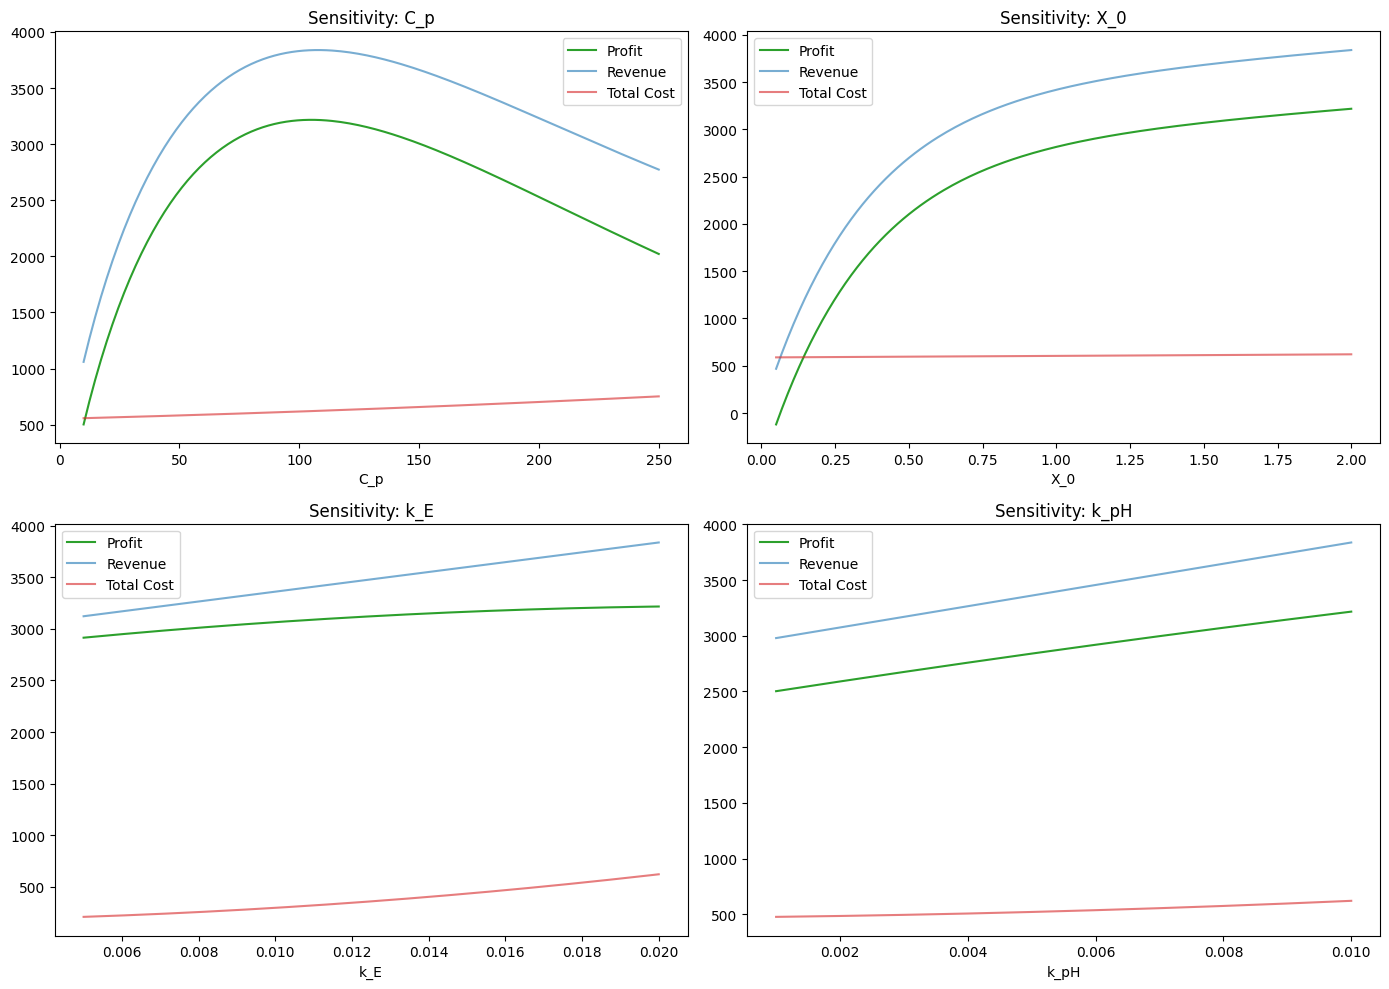

In [227]:
# 1) Sensitivity plots for profit and components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
vars_names = ['C_p', 'X_0', 'k_E', 'k_pH']
bounds_list = [bounds[0], bounds[1], bounds[2], bounds[3]]
opt_vals = [C_p_opt, X_0_opt, k_E_opt, k_pH_opt]
for i, ax in enumerate(axes.flatten()):
    lower, upper = bounds_list[i]
    xs = np.linspace(lower, upper, 200)
    profits = []
    revenues = []
    costs = []
    for xval in xs:
        x = opt_vals.copy()
        x[i] = xval
        comp = profit_components_from_x(x)
        profits.append(comp['profit'])
        revenues.append(comp['revenue'])
        costs.append(comp['total_cost'])
    ax.plot(xs, profits, label='Profit', color='tab:green')
    ax.plot(xs, revenues, label='Revenue', color='tab:blue', alpha=0.6)
    ax.plot(xs, costs, label='Total Cost', color='tab:red', alpha=0.6)
    # ax.axvline(opt_vals[i], color='k', linestyle='--', label='Optimum')
    ax.set_title(f'Sensitivity: {vars_names[i]}')
    ax.set_xlabel(vars_names[i])
    ax.legend()
plt.tight_layout()
plt.show()


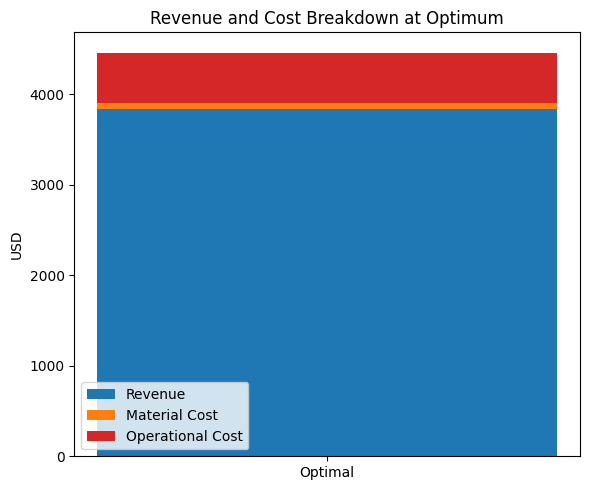

In [228]:
# 2) Revenue vs Cost stacked bar at optimum
labels = ['Revenue', 'Material Cost', 'Operational Cost']
values = [revenue_opt, material_cost_opt, operational_cost_opt]
fig, ax = plt.subplots(figsize=(6,5))
ax.bar(['Optimal'], [values[0]], label='Revenue', color='tab:blue')
ax.bar(['Optimal'], [values[1]], bottom=[values[0]], label='Material Cost', color='tab:orange')
ax.bar(['Optimal'], [values[2]], bottom=[values[0]+values[1]], label='Operational Cost', color='tab:red')
ax.set_ylabel('USD')
ax.set_title('Revenue and Cost Breakdown at Optimum')
ax.legend()
plt.tight_layout()
plt.show()


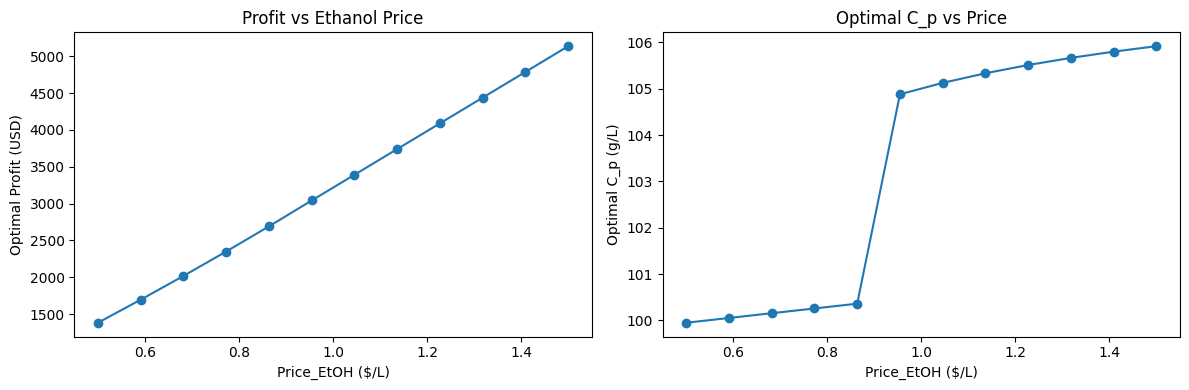

In [229]:
# 5) Parameter sweep: optimal profit vs Price_EtOH (re-optimize for each price)
prices = np.linspace(0.5 * Price_EtOH, 1.5 * Price_EtOH, 12)
opt_profits = []
opt_Cp = []
for p in prices:
    R0_new = p * V * Y_max
    res = optimize_with_params(R0_override=R0_new)
    profit_at_res = -res.fun if res.success else np.nan
    opt_profits.append(profit_at_res)
    if res.success:
        opt_Cp.append(res.x[0])
    else:
        opt_Cp.append(np.nan)
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(prices, opt_profits, '-o')
ax[0].set_xlabel('Price_EtOH ($/L)')
ax[0].set_ylabel('Optimal Profit (USD)')
ax[0].set_title('Profit vs Ethanol Price')
ax[1].plot(prices, opt_Cp, '-o')
ax[1].set_xlabel('Price_EtOH ($/L)')
ax[1].set_ylabel('Optimal C_p (g/L)')
ax[1].set_title('Optimal C_p vs Price')
plt.tight_layout()
plt.show()


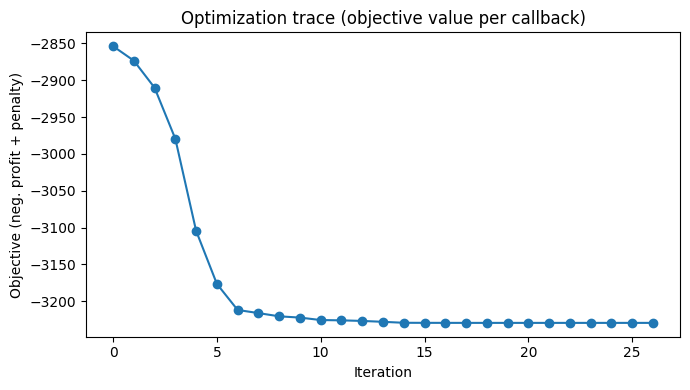

In [230]:
# 8) Optimization trace: re-run with callback to capture objective per iteration
history = {'x': [], 'fun': []}
def cb(xk):
    history['x'].append(np.copy(xk))
    history['fun'].append(obj_wrapper(xk))

res_trace = minimize(obj_wrapper, initial_guess, method='BFGS', options={'maxiter':500, 'gtol':1e-6, 'disp':False}, callback=cb)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.arange(len(history['fun'])), history['fun'], '-o')
ax.set_xlabel('Iteration')
ax.set_ylabel('Objective (neg. profit + penalty)')
ax.set_title('Optimization trace (objective value per callback)')
plt.tight_layout()
plt.show()



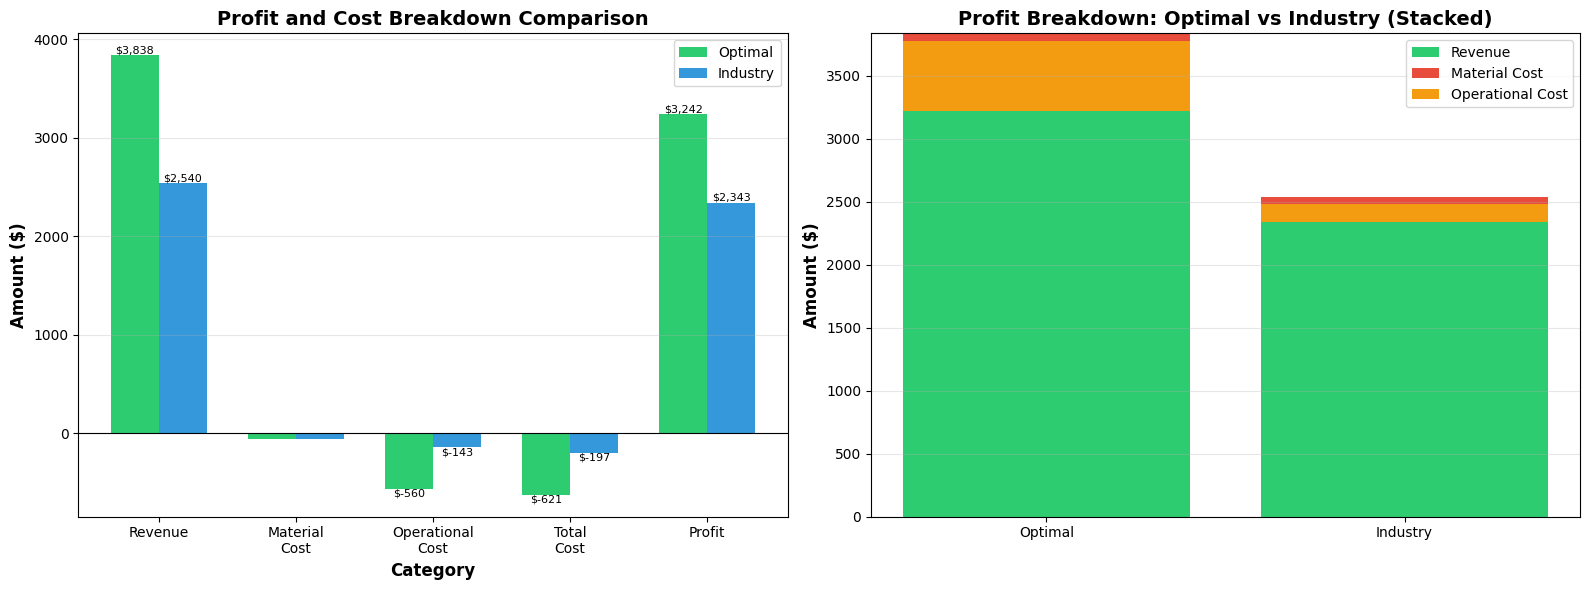


Visualizations completed!


In [252]:
industry_C_p = 120  # g/L (typical glucose concentration)
industry_X_0 = 0.8  # g/L (typical initial biomass)
industry_k_E = 0.01  # typical temperature controller gain
industry_k_pH = 0.005  # typical pH controller gain

industry_x = np.array([industry_C_p, industry_X_0, industry_k_E, industry_k_pH])

# Calculate profit at industry values
# Revenue components
monod_ind = industry_C_p / (K_s + industry_C_p)
biomass_sat_ind = 1 - np.exp(-alpha_R * industry_X_0)
inhib_ind = 1 - (industry_C_p**2) / (C_inhib**2 + industry_C_p**2)
interaction_rev_ind = 1 + gamma_1 * industry_C_p * industry_X_0 + gamma_2 * industry_k_E * industry_k_pH
industry_revenue = R_0 * monod_ind * biomass_sat_ind * inhib_ind * interaction_rev_ind

# Cost components
industry_material_cost = a_1*industry_C_p + a_2*industry_C_p**2 + b_1*industry_X_0 + b_2*industry_X_0**2 + c_1*industry_C_p*industry_X_0
industry_operational_cost = d_1*industry_k_E**2 + d_2*industry_k_pH**2 + d_3*industry_k_E*industry_k_pH + e_1*industry_C_p*industry_k_E + e_2*industry_X_0*industry_k_pH
industry_total_cost = industry_material_cost + industry_operational_cost
industry_profit = industry_revenue - industry_total_cost

# Prepare data for comparison
optimal_breakdown = {
    'Revenue': revenue_opt,
    'Material Cost': material_cost_opt,
    'Operational Cost': operational_cost_opt,
    'Total Cost': total_cost_opt,
    'Profit': optimal_profit
}

industry_breakdown = {
    'Revenue': industry_revenue,
    'Material Cost': industry_material_cost,
    'Operational Cost': industry_operational_cost,
    'Total Cost': industry_total_cost,
    'Profit': industry_profit
}

# Create comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

categories = ['Revenue', 'Material\nCost', 'Operational\nCost', 'Total\nCost', 'Profit']
optimal_values = [
    optimal_breakdown['Revenue'],
    -optimal_breakdown['Material Cost'],
    -optimal_breakdown['Operational Cost'],
    -optimal_breakdown['Total Cost'],
    optimal_breakdown['Profit']
]
industry_values = [
    industry_breakdown['Revenue'],
    -industry_breakdown['Material Cost'],
    -industry_breakdown['Operational Cost'],
    -industry_breakdown['Total Cost'],
    industry_breakdown['Profit']
]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, optimal_values, width, label='Optimal', color='#2ecc71')
bars2 = ax1.bar(x + width/2, industry_values, width, label='Industry', color='#3498db')

ax1.set_xlabel('Category', fontsize=12, fontweight='bold')
ax1.set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
ax1.set_title('Profit and Cost Breakdown Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(0, color='black', linewidth=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 100:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'${height:,.0f}',
                    ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# Stacked area comparison (profit and costs)
x_pos = ['Optimal', 'Industry']
ax2.bar(x_pos, [revenue_opt, industry_revenue], label='Revenue', color='#2ecc71')
ax2.bar(x_pos, [-material_cost_opt, -industry_material_cost], 
       bottom=[revenue_opt, industry_revenue],
       label='Material Cost', color='#e74c3c')
ax2.bar(x_pos, [-operational_cost_opt, -industry_operational_cost],
       bottom=[revenue_opt - material_cost_opt, industry_revenue - industry_material_cost],
       label='Operational Cost', color='#f39c12')

ax2.set_ylabel('Amount ($)', fontsize=12, fontweight='bold')
ax2.set_title('Profit Breakdown: Optimal vs Industry (Stacked)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nVisualizations completed!")